<a href="https://colab.research.google.com/github/KimaniKibuthu/cassava-leaf-disease-classification/blob/main/Cassava_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cassava Leaf Disease Classification

## Introduction

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

## Methodology

1. Data Collection
2. Data Preparation
3. Modelling

# Libraries, Variables & Functions

In [1]:
# The necessary libraries
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB7, ResNet101



In [2]:
# Variables
train_path = '/content/train_images'
test_path = '/content/test_images'

train_size=0.9
random_state = 42

epochs = 10
batch_size = 64


In [3]:
def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **accuracy**

    :param all: bool
    default=True. If true, overrides metric and plots figures of accuracy and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation Accuracy',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train Accuracy',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation Accuracy plots',
                             xaxis_title='Epochs',
                             yaxis_title='Accuracy')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['accuracy']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='Accuracy',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='Accuracy plot',
                             xaxis_title='Epochs',
                             yaxis_title='Accuracy')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


# Data Collection

The data was obtained from kaggle: [Cassava Data](https://www.kaggle.com/c/cassava-leaf-disease-classification/data)

In [4]:
!pip uninstall -y kaggle
!pip install kaggle

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=6d4802b355d24e2fe6fbff0067cedf2db56a7fb521667a1562322cc961816ba3
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle


In [5]:
# Credentials
os.environ["KAGGLE_USERNAME"] = 'kimanikibuthu'
os.environ["KAGGLE_KEY"] = 'f85c0bb5d43058fddcce7902e1325677'

In [6]:
# Get the data
!kaggle competitions download -c cassava-leaf-disease-classification


100% 5.74G/5.76G [02:06<00:00, 46.7MB/s]
100% 5.76G/5.76G [02:06<00:00, 48.8MB/s]


In [7]:
!unzip /content/cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954399974.jpg  
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  in

In [8]:
# Load csv files 
train = pd.read_csv('/content/train.csv')
submission = pd.read_csv('/content/sample_submission.csv')


# Data Preparation

Prepare the data for modelling.

## Exploration

**General Exploration**

In [9]:
# View the data
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [10]:
# View labels
with open('/content/label_num_to_disease_map.json', 'r') as file:
  labels = (json.load(file))

print(labels)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


**Distribution of Examples**

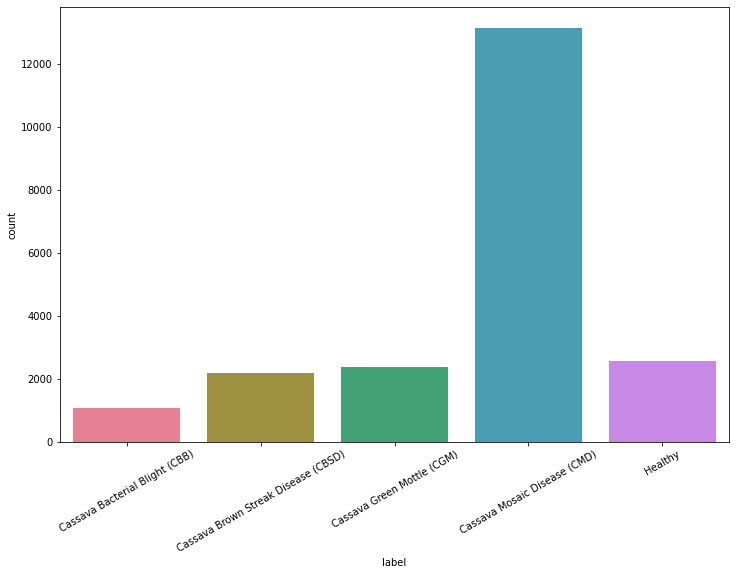

In [11]:
# Visualize
plt.figure(figsize=(12,8))
sns.countplot(x='label', 
              data=train,
              palette='husl').set_xticklabels(labels=list(labels.values()),
                                              rotation=30);

In [12]:
# View value counts
train.label.value_counts(normalize=True)*100

3    61.494602
4    12.043744
2    11.151096
1    10.230406
0     5.080151
Name: label, dtype: float64

In [13]:
# Model weights
weights = {
    0:10.0,
    1:5.0,
    2:4.5455,
    3:0.81314,
    4:4.1667
}

There is some clear imbalance in the data, hence that needs to be taken care of.

**Cassava Bacterial Blight (CBB)**

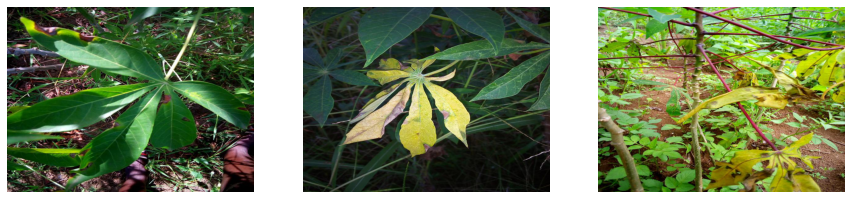

In [14]:
path = "/content/train_images/"
df0 = train[train["label"] == 0]
files = df0["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()



**Cassava Brown Streak Disease (CBSD)**

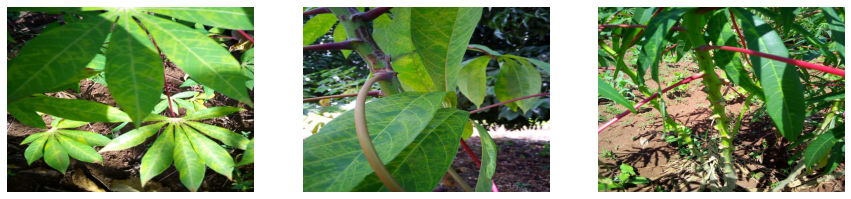

In [15]:
df1 = train[train['label']==1]
brown_images_samples = df1['image_id'].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for images in brown_images_samples:
  image = Image.open(path + images)
  plt.subplot(1, 3, index+1)
  plt.imshow(image)
  plt.axis('off')
  index +=1

plt.show()


**Cassava Green Mottle (CGM)**

<function matplotlib.pyplot.show>

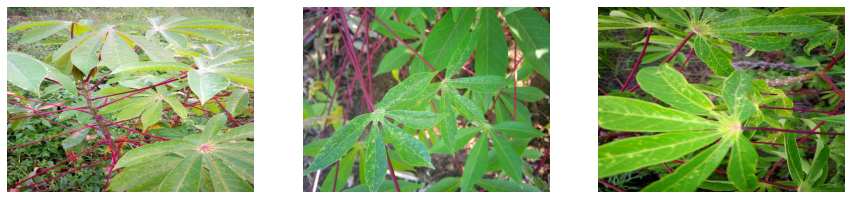

In [16]:
df2 = train[train['label']==2]
mottle_images_samples = df2['image_id'].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for images in mottle_images_samples:
  image = Image.open(path + images)
  plt.subplot(1, 3, index+1)
  plt.imshow(image)
  plt.axis('off')
  index +=1

plt.show

**Cassava Mosaic Disease (CMD)**

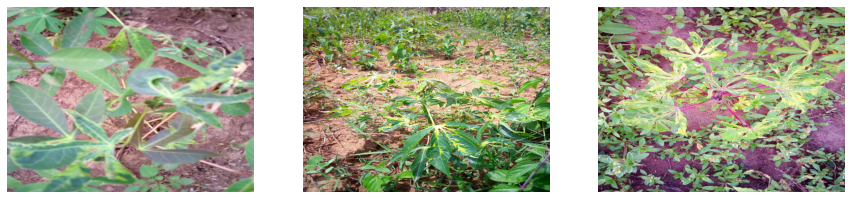

In [17]:
df3 = train[train['label']==3]
mosaic_images_samples = df3['image_id'].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for images in mosaic_images_samples:
  image = Image.open(path + images)
  plt.subplot(1, 3, index+1)
  plt.imshow(image)
  plt.axis('off')
  index +=1

plt.show()

**Healthy**

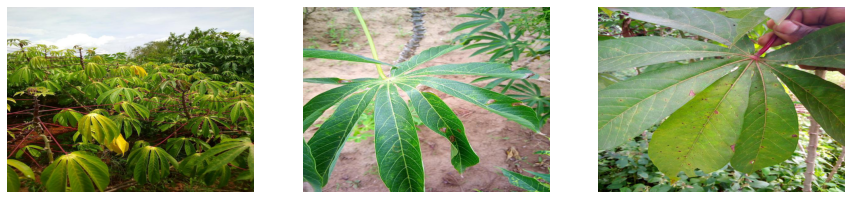

In [18]:
df4 = train[train['label']==4]
healthy_images_samples = df4['image_id'].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for images in healthy_images_samples:
  image = Image.open(path + images)
  plt.subplot(1, 3, index+1)
  plt.imshow(image)
  plt.axis('off')
  index +=1

plt.show()

## Preprocessing

In [19]:
from google.colab.patches import cv2_imshow

**Preprocessing**

In [20]:
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, 
#     RandomContrast, HorizontalFlip,Rotate
# )

In [25]:
# def preprocess(image):
#   transforms = Compose([
#             Rotate(limit=40),
#             RandomBrightness(limit=0.1),
#             JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             RandomContrast(limit=0.2, p=0.5),
#             HorizontalFlip(),
#         ])
  

#   data = {'image': image}

#   x = transforms(**data)

#   aug_image = x['image']

#   return aug_image


In [27]:
# Check the size of an image

image_path = os.path.join(train_path, train.image_id.values[1])

width, height = Image.open(image_path).size

print(f'The image has a width of {width} and a height of {height}')

The image has a width of 800 and a height of 600


In [28]:
# Split the data
train_set, val_set = train_test_split(train,
                              train_size= train_size,
                              random_state = random_state,
                              stratify = train['label'])

In [29]:
# Convert to strings
train_set['label'] = train_set['label'].astype(str)
val_set['label'] = val_set['label'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
# Image Data Generator

# Train
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                   rotation_range =40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [1.0, 2.0],
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'reflect',
                                   rescale=1./255) 
                                   
# Validation
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                 rescale=1./255)

# Test
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                  rescale=1./255)


In [44]:
# Instantiate the flows

# Train
train_flow = train_datagen.flow_from_dataframe(train_set,
                                               train_path,
                                               x_col='image_id',
                                               y_col='label',
                                               target_size=(300,300),
                                               class_mode='categorical',
                                               batch_size=batch_size)

# Validation
val_flow = val_datagen.flow_from_dataframe(val_set,
                                               train_path,
                                               x_col='image_id',
                                               y_col='label',
                                               target_size=(300,300),
                                               class_mode='categorical',
                                               batch_size=batch_size)




Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


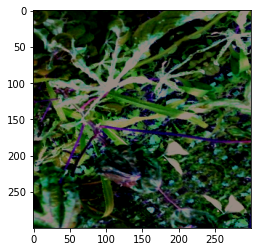

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


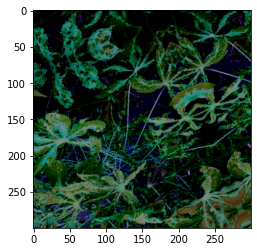

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


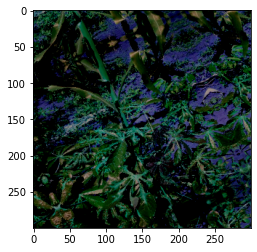

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


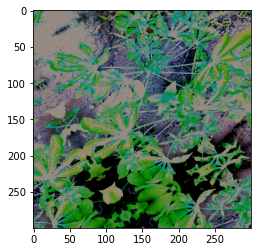

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


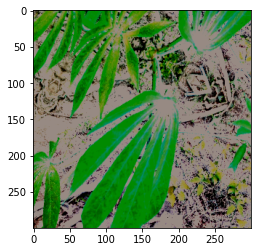

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


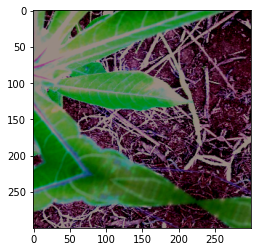

In [45]:
# Visualize an image
x_batch, y_batch = next(train_flow)
for i in range (0,6):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

# Modelling

Create a using ResNet

In [ ]:
# from keras.callbacks import LearningRateScheduler

# sd=[]
# class LossHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = [1,1]

#     def on_epoch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))
#         sd.append(step_decay(len(self.losses)))
#         print('lr:', step_decay(len(self.losses)))


# learning_rate = 0.001
# decay_rate = 5e-6
# momentum = 0.9

# rmsprop = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, 
#                                       momentum=momentum)


# def step_decay(losses):
#     if float(2*np.sqrt(np.array(history.losses[-1])))<0.3:
#         lrate=0.01*1/(1+0.1*len(history.losses))
#         momentum=0.8
#         decay_rate=2e-6
#         return lrate
#     else:
#         lrate=0.1
#         return lrate

# history=LossHistory()
# lrate=LearningRateScheduler(step_decay)

In [46]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.01,
                                                   name='categorical_crossentropy' )

adam = tf.keras.optimizers.Adam(0.001)

In [47]:
# Define callback
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=5)

# Save the model with the minimum validation loss
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Cassava_best_model.h5",
                                    save_best_only=True,
                                    monitor = 'categorical_accuracy',
                                    mode='max')
    
# reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)

callbacks = [early_stopper, checkpoint_cb, reduce_lr]

In [31]:
# Let's take a look to see how many layers are in the base model
# base_model.trainable=True
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

In [49]:
# Initialize model
 
resnet = ResNet101(include_top=False,
                          input_shape=(300,300,3))

resnet.trainable=True

print("Number of layers in the base model: ", len(resnet.layers))

# # Fine-tune from this layer onwards
fine_tune_at = 313

# # Freeze all the layers before the `fine_tune_at` layer
for layer in resnet.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  345


In [33]:
resnet.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [50]:
# Create model

model = Sequential([
                    resnet,
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(0.5),
                    Dense(5, activation='softmax')
])

model.compile(loss=loss,
              optimizer=adam,
              metrics=['categorical_accuracy'])

In [51]:
# Train model
history = model.fit(train_flow,
                    epochs=10,
                    steps_per_epoch=int(np.ceil(len(train_set)/batch_size)),
                    callbacks=callbacks,
                    validation_data=val_flow,
                    validation_steps=int(np.ceil(len(val_set)/batch_size))

                    )

Epoch 1/10
301/301 [==============================] - 651s 2s/step - loss: 2.4585 - categorical_accuracy: 0.6058 - val_loss: 1.2047 - val_categorical_accuracy: 0.6150


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
301/301 [==============================] - 601s 2s/step - loss: 1.1598 - categorical_accuracy: 0.6176 - val_loss: 1.2378 - val_categorical_accuracy: 0.5318
Epoch 3/10
301/301 [==============================] - 586s 2s/step - loss: 1.1408 - categorical_accuracy: 0.6181 - val_loss: 1.2375 - val_categorical_accuracy: 0.6107

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
301/301 [==============================] - 585s 2s/step - loss: 1.1258 - categorical_accuracy: 0.6185 - val_loss: 1.0809 - val_categorical_accuracy: 0.6243
Epoch 5/10
301/301 [==============================] - 587s 2s/step - loss: 1.1193 - categorical_accuracy: 0.6180 - val_loss: 1.0747 - val_categorical_accuracy: 0.6243
Epoch 6/10
301/301 [==============================] - 582s 2s/step - loss: 1.1168 - categorical_accuracy: 0.6204 - val_loss: 1.0823 - val_categorical_accuracy: 0.6182
Epoch 7/10
301/301 [==============================] - 583s 2s/step - loss: 1.1108 -

In [1]:
# Plot
plot_interactive_figures(history, metric='loss')

NameError: ignored